In [1]:
import numpy as np
# import cv2
import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim
import torchvision
import torchvision.transforms.functional as tf
import torchvision.transforms as tfs
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.models as models
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime
import random
import time
import copy
import warnings
warnings.filterwarnings("ignore") # 忽略警告
# from tifffile import TIFF
# import tifffile as tiff
try: # for torchvision<0.4
    from torchvision.models.utils import load_state_dict_from_url
except: # for torchvision>=0.4
    from torch.hub import load_state_dict_from_url
from collections import OrderedDict
import math
import torch.utils.checkpoint as cp
from torchvision.models._utils import IntermediateLayerGetter
# import tensorboardX
# from tensorboardX import SummaryWriter
import json

## 预处理

In [2]:
############ GID数据集 ###############
COLORCLASS_16c = ('Background','Industrial land','Urban residential','Rural residential','Traffic land',
          'Garden land','Arbor forest','Shrub land',
          'Paddy field','Irrigated land','Dry cropland',
          'Natural meadow','Artificial meadow',
          'River','Lake','Pond')

COLORMAP_16c = [[0, 0, 0],[200,0,0],[250,0,150],[200,150,150],[250,150,150],
            [200,0,200],[150,0,250],[150,150,250],
            [0,200,0],[150,250,0],[150,200,150],
            [250,200,0],[200,200,0],
            [0,0,200],[0,150,200],[0,200,250]]

COLORCLASS_6c = ['Background','Building','Forest','Farmland','Meadow','Water']

COLORMAP_6c = [[0, 0, 0],[255, 0, 0],[0, 255, 255],[0, 255, 0], [255, 255, 0],[0, 0, 255]]

cm2lbl_16 = np.zeros(256**3)
cm2lbl_6 = np.zeros(256**3)

# 枚举的时候i是下标，cm是一个三元组，分别标记了RGB值
for i, cm in enumerate(COLORMAP_16c):
    cm2lbl_16[(cm[0]*256 + cm[1])*256 + cm[2]] = i
for i, cm in enumerate(COLORMAP_6c):
    cm2lbl_6[(cm[0]*256 + cm[1])*256 + cm[2]] = i
    
# 将标签按照RGB值填入对应类别的下标信息
def image2label_16(im):
    data = np.array(im, dtype="int32")
    idx = (data[:,:,0]*256 + data[:,:,1])*256 + data[:,:,2]
    return np.array(cm2lbl_16[idx], dtype="int64")

def image2label_6(im):
    data = np.array(im, dtype="int32")
    idx = (data[:,:,0]*256 + data[:,:,1])*256 + data[:,:,2]
    return np.array(cm2lbl_6[idx], dtype="int64")


In [3]:
gid_root = r"D:\TSL\data\GID10_clip"
def read_images(root=gid_root, train=True):
    txt_fname = root + '/'+('train.txt' if train else 'val.txt')
    # print(txt_fname)
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root,'images',i+'.tif') for i in images]
    label1 = [os.path.join(root,'gtCoarse',i+'.tif') for i in images]
    label2 = [os.path.join(root,'gtFine',i+'.tif') for i in images]
    return data, label1, label2

In [4]:
def image_transforms(data,label1,label2): 
    # 将数据转换成tensor，并且做标准化处理

    im_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    # label_tfs = tfs.ToTensor()

    data = im_tfs(data)
    # print(data)
    label1 = image2label_6(label1)
    label1 = torch.from_numpy(label1)
    label2 = image2label_16(label2)
    label2 = torch.from_numpy(label2)
    # label1 = label_tfs(label1)
    # label2 = label_tfs(label2)
    # label = torch.from_numpy(label)# 将numpy数组转换成tensor
    return data,label1,label2

In [5]:
class GIDSegDataset(torch.utils.data.Dataset):
    
    # 构造函数
    def __init__(self, train, height, width, transforms):

        self.height = height
        self.width = width
        self.fnum = 0    # 用来记录被过滤的图片数
        self.transforms = transforms
        data_list, label1_list, label2_list = read_images(train=train)
        # data_list, label_list= read_images(train=train)
        self.data_list = self._filter(data_list)
        self.label1_list = self._filter(label1_list)
        self.label2_list = self._filter(label2_list)
        # self.label_list = self._filter(label_list)
        if(train==True):
            print("训练集：加载了 " + str(len(self.data_list)) + " 张图片和标签" + ",过滤了" + str(self.fnum) + "张图片")
        else:
            print("测试集：加载了 " + str(len(self.data_list)) + " 张图片和标签" + ",过滤了" + str(self.fnum) + "张图片")
        
    
    # 过滤掉长小于height和宽小于width的图片
    def _filter(self, images): 
        img = []
        for im in images:
            if (Image.open(im).size[1] >= self.height and 
               Image.open(im).size[0] >= self.width):
                img.append(im)
            else:
                self.fnum  = self.fnum+1
        return img
    
    # 重载getitem函数，使类可以迭代
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label1 = self.label1_list[idx]
        label2 = self.label2_list[idx]
        # label =self.label_list[idx]
        
        img = Image.open(img)
        # label1 = cv2.imread(label1,cv2.IMREAD_GRAYSCALE)
        # label2 = cv2.imread(label2,cv2.IMREAD_GRAYSCALE)
        label1 = Image.open(label1).convert('RGB')
        label2 = Image.open(label2).convert('RGB')
        img, label1,label2  = self.transforms(img, label1,label2)
        # img, label1, label2 = self.transforms(img, label1, label2)
        return img, label1,label2
    
    def __len__(self):
        return len(self.data_list)

In [6]:
'''
image=(C,H,W)
label=(H,W)
'''
height = 512
width = 512
gid_train = GIDSegDataset(True, height, width, image_transforms)
gid_val = GIDSegDataset(False, height, width, image_transforms)
train_data = DataLoader(gid_train, batch_size=16,shuffle=True)#,num_workers=8
valid_data = DataLoader(gid_val, batch_size=16)#,num_workers=8

训练集：加载了 5760 张图片和标签,过滤了0张图片
测试集：加载了 640 张图片和标签,过滤了0张图片


In [15]:
gid_val[0]

(tensor([[[ 0.5193,  0.3481,  0.4851,  ...,  0.2796,  0.2453,  0.3138],
          [ 0.6221,  0.5878,  0.5536,  ...,  0.2796,  0.2453,  0.2453],
          [ 0.7933,  0.9988,  0.7591,  ...,  0.2453,  0.2111,  0.2111],
          ...,
          [-0.7650, -0.9020, -0.8678,  ..., -0.6623, -0.0801,  0.4508],
          [-0.9363, -1.0048, -1.0562,  ..., -1.1589, -1.0048, -0.7650],
          [-1.1247, -1.1247, -1.1247,  ..., -0.6623, -0.7308, -0.9363]],
 
         [[ 0.5028,  0.5028,  0.8354,  ..., -0.0049,  0.0476,  0.0476],
          [ 0.6954,  0.5028,  0.8880,  ...,  0.1001, -0.0049, -0.0049],
          [ 0.8354,  1.1506,  0.7479,  ...,  0.0476, -0.0049, -0.0049],
          ...,
          [-0.4076, -0.4426, -0.4076,  ..., -0.7577, -0.1975,  0.4503],
          [-0.3550, -0.3550, -0.4076,  ..., -1.1429, -1.2479, -1.0028],
          [-0.3025, -0.3550, -0.4076,  ..., -0.4426, -0.6527, -1.0028]],
 
         [[ 1.5245,  1.7163,  2.0300,  ...,  0.4091,  0.4788,  0.4788],
          [ 1.5245,  1.4025,

## 模型

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import timm


class ConvBNReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, stride=1, norm_layer=nn.BatchNorm2d, bias=False):
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, bias=bias,
                      dilation=dilation, stride=stride, padding=((stride - 1) + dilation * (kernel_size - 1)) // 2),
            norm_layer(out_channels),
            nn.ReLU6()
        )


class ConvBN(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, stride=1, norm_layer=nn.BatchNorm2d, bias=False):
        super(ConvBN, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, bias=bias,
                      dilation=dilation, stride=stride, padding=((stride - 1) + dilation * (kernel_size - 1)) // 2),
            norm_layer(out_channels)
        )


class Conv(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, stride=1, bias=False):
        super(Conv, self).__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, bias=bias,
                      dilation=dilation, stride=stride, padding=((stride - 1) + dilation * (kernel_size - 1)) // 2)
        )


class SeparableConvBNReLU(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1,
                 norm_layer=nn.BatchNorm2d):
        super(SeparableConvBNReLU, self).__init__(
            nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, dilation=dilation,
                      padding=((stride - 1) + dilation * (kernel_size - 1)) // 2,
                      groups=in_channels, bias=False),
            norm_layer(out_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.ReLU6()
        )


class SeparableConvBN(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1,
                 norm_layer=nn.BatchNorm2d):
        super(SeparableConvBN, self).__init__(
            nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, dilation=dilation,
                      padding=((stride - 1) + dilation * (kernel_size - 1)) // 2,
                      groups=in_channels, bias=False),
            norm_layer(out_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        )


class SeparableConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dilation=1):
        super(SeparableConv, self).__init__(
            nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, dilation=dilation,
                      padding=((stride - 1) + dilation * (kernel_size - 1)) // 2,
                      groups=in_channels, bias=False),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        )


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.ReLU6, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1, 1, 0, bias=True)
        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1, 1, 0, bias=True)
        self.drop = nn.Dropout(drop, inplace=True)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

#全局注意力
class GlobalLocalAttention(nn.Module):
    def __init__(self,
                 dim=256,
                 num_heads=16,
                 qkv_bias=False,
                 window_size=8,
                 relative_pos_embedding=True
                 ):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // self.num_heads
        self.scale = head_dim ** -0.5
        self.ws = window_size

        self.qkv = Conv(dim, 3*dim, kernel_size=1, bias=qkv_bias)
        self.local1 = ConvBN(dim, dim, kernel_size=3)
        self.local2 = ConvBN(dim, dim, kernel_size=1)
        self.proj = SeparableConvBN(dim, dim, kernel_size=window_size)

        self.attn_x = nn.AvgPool2d(kernel_size=(window_size, 1), stride=1,  padding=(window_size//2 - 1, 0))
        self.attn_y = nn.AvgPool2d(kernel_size=(1, window_size), stride=1, padding=(0, window_size//2 - 1))

        self.relative_pos_embedding = relative_pos_embedding

        if self.relative_pos_embedding:
            # define a parameter table of relative position bias
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

            # get pair-wise relative position index for each token inside the window
            coords_h = torch.arange(self.ws)
            coords_w = torch.arange(self.ws)
            coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
            coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
            relative_coords[:, :, 0] += self.ws - 1  # shift to start from 0
            relative_coords[:, :, 1] += self.ws - 1
            relative_coords[:, :, 0] *= 2 * self.ws - 1
            relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
            self.register_buffer("relative_position_index", relative_position_index)

            trunc_normal_(self.relative_position_bias_table, std=.02)

    def pad(self, x, ps):
        _, _, H, W = x.size()
        if W % ps != 0:
            x = F.pad(x, (0, ps - W % ps), mode='reflect')
        if H % ps != 0:
            x = F.pad(x, (0, 0, 0, ps - H % ps), mode='reflect')
        return x

    def pad_out(self, x):
        x = F.pad(x, pad=(0, 1, 0, 1), mode='reflect')
        return x

    def forward(self, x):
        B, C, H, W = x.shape

        local = self.local2(x) + self.local1(x)

        x = self.pad(x, self.ws)
        B, C, Hp, Wp = x.shape
        qkv = self.qkv(x)

        q, k, v = rearrange(qkv, 'b (qkv h d) (hh ws1) (ww ws2) -> qkv (b hh ww) h (ws1 ws2) d', h=self.num_heads,
                            d=C//self.num_heads, hh=Hp//self.ws, ww=Wp//self.ws, qkv=3, ws1=self.ws, ws2=self.ws)

        dots = (q @ k.transpose(-2, -1)) * self.scale

        if self.relative_pos_embedding:
            relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                self.ws * self.ws, self.ws * self.ws, -1)  # Wh*Ww,Wh*Ww,nH
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
            dots += relative_position_bias.unsqueeze(0)

        attn = dots.softmax(dim=-1)
        attn = attn @ v

        attn = rearrange(attn, '(b hh ww) h (ws1 ws2) d -> b (h d) (hh ws1) (ww ws2)', h=self.num_heads,
                         d=C//self.num_heads, hh=Hp//self.ws, ww=Wp//self.ws, ws1=self.ws, ws2=self.ws)

        attn = attn[:, :, :H, :W]

        out = self.attn_x(F.pad(attn, pad=(0, 0, 0, 1), mode='reflect')) + \
              self.attn_y(F.pad(attn, pad=(0, 1, 0, 0), mode='reflect'))

        out = out + local
        out = self.pad_out(out)
        out = self.proj(out)
        # print(out.size())
        out = out[:, :, :H, :W]

        return out


class Block(nn.Module):
    def __init__(self, dim=256, num_heads=16,  mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.ReLU6, norm_layer=nn.BatchNorm2d, window_size=8):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = GlobalLocalAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias, window_size=window_size)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, out_features=dim, act_layer=act_layer, drop=drop)
        self.norm2 = norm_layer(dim)

    def forward(self, x):

        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class WF(nn.Module):
    def __init__(self, in_channels=128, decode_channels=128, eps=1e-8):
        super(WF, self).__init__()
        self.pre_conv = Conv(in_channels, decode_channels, kernel_size=1)

        self.weights = nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)
        self.eps = eps
        self.post_conv = ConvBNReLU(decode_channels, decode_channels, kernel_size=3)

    def forward(self, x, res):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        weights = nn.ReLU()(self.weights)
        fuse_weights = weights / (torch.sum(weights, dim=0) + self.eps)
        x = fuse_weights[0] * self.pre_conv(res) + fuse_weights[1] * x
        x = self.post_conv(x)
        return x


class FeatureRefinementHead(nn.Module):
    def __init__(self, in_channels=64, decode_channels=64):
        super().__init__()
        self.pre_conv = Conv(in_channels, decode_channels, kernel_size=1)

        self.weights = nn.Parameter(torch.ones(2, dtype=torch.float32), requires_grad=True)
        self.eps = 1e-8
        self.post_conv = ConvBNReLU(decode_channels, decode_channels, kernel_size=3)

        self.pa = nn.Sequential(nn.Conv2d(decode_channels, decode_channels, kernel_size=3, padding=1, groups=decode_channels),
                                nn.Sigmoid())
        self.ca = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                Conv(decode_channels, decode_channels//16, kernel_size=1),
                                nn.ReLU6(),
                                Conv(decode_channels//16, decode_channels, kernel_size=1),
                                nn.Sigmoid())

        self.shortcut = ConvBN(decode_channels, decode_channels, kernel_size=1)
        self.proj = SeparableConvBN(decode_channels, decode_channels, kernel_size=3)
        self.act = nn.ReLU6()

    def forward(self, x, res):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        weights = nn.ReLU()(self.weights)
        fuse_weights = weights / (torch.sum(weights, dim=0) + self.eps)
        x = fuse_weights[0] * self.pre_conv(res) + fuse_weights[1] * x
        x = self.post_conv(x)
        shortcut = self.shortcut(x)
        pa = self.pa(x) * x
        ca = self.ca(x) * x
        x = pa + ca
        x = self.proj(x) + shortcut
        x = self.act(x)

        return x


class AuxHead(nn.Module):

    def __init__(self, in_channels=64, num_classes=8):
        super().__init__()
        self.conv = ConvBNReLU(in_channels, in_channels)
        self.drop = nn.Dropout(0.1)
        self.conv_out = Conv(in_channels, num_classes, kernel_size=1)

    def forward(self, x, h, w):
        feat = self.conv(x)
        feat = self.drop(feat)
        feat = self.conv_out(feat)
        feat = F.interpolate(feat, size=(h, w), mode='bilinear', align_corners=False)
        return feat


class Decoder(nn.Module):
    def __init__(self,
                 encoder_channels=(64, 128, 256, 512),
                 decode_channels=64,
                 dropout=0.1,
                 window_size=8,
                 num_classes=6):
        super(Decoder, self).__init__()

        self.pre_conv = ConvBN(encoder_channels[-1], decode_channels, kernel_size=1)
        self.b4 = Block(dim=decode_channels, num_heads=8, window_size=window_size)

        self.b3 = Block(dim=decode_channels, num_heads=8, window_size=window_size)
        self.p3 = WF(encoder_channels[-2], decode_channels)

        self.b2 = Block(dim=decode_channels, num_heads=8, window_size=window_size)
        self.p2 = WF(encoder_channels[-3], decode_channels)

        if self.training:
            self.up4 = nn.UpsamplingBilinear2d(scale_factor=4)
            self.up3 = nn.UpsamplingBilinear2d(scale_factor=2)
            self.aux_head = AuxHead(decode_channels, num_classes)

        self.p1 = FeatureRefinementHead(encoder_channels[-4], decode_channels)

        self.segmentation_head = nn.Sequential(ConvBNReLU(decode_channels, decode_channels),
                                               nn.Dropout2d(p=dropout, inplace=True),
                                               Conv(decode_channels, num_classes, kernel_size=1))
        self.init_weight()

    def forward(self, res1, res2, res3, res4, h, w):
        if self.training:
            x = self.b4(self.pre_conv(res4))
            h4 = self.up4(x)

            x = self.p3(x, res3)
            x = self.b3(x)
            h3 = self.up3(x)

            x = self.p2(x, res2)
            x = self.b2(x)
            h2 = x
            x = self.p1(x, res1)
            # print('x',x.shape)
            x_s = F.interpolate(x, size=res4.shape[-2:], mode='bilinear', align_corners=True)
            # print('x_s',x_s.shape)
            x = self.segmentation_head(x)
            
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)

            ah = h4 + h3 + h2
            ah = self.aux_head(ah, h, w)

            return x,x_s
        else:
            x = self.b4(self.pre_conv(res4))
            x = self.p3(x, res3)
            x = self.b3(x)

            x = self.p2(x, res2)
            x = self.b2(x)

            x = self.p1(x, res1)
            x_s = F.interpolate(x, size=res4.shape[-2:], mode='bilinear', align_corners=True)
            x = self.segmentation_head(x)
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)

            return x,x_s

    def init_weight(self):
        for m in self.children():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, a=1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


class UNetFormer(nn.Module):
    def __init__(self,
                 decode_channels=64,
                 dropout=0.1,
                 backbone_name='resnet50',
                 pretrained=True,
                 window_size=8,
                 num_classes=16
                 ):
        super().__init__()

        self.backbone = timm.create_model(backbone_name, features_only=True, output_stride=32,
                                          out_indices=(1, 2, 3, 4), pretrained=pretrained, 
                                          pretrained_cfg_overlay=dict(file='D:/TSL/multimask/model_data/resnet50_a1_0-14fe96d1.pth'))
        encoder_channels = [self.backbone.feature_info.channels(),[256, 512, 1024, 2112]]
        # print('encoder_channels',encoder_channels)
        self.class_nb1 = 6
        self.class_nb2 = 16
        self.logsigma = nn.Parameter(torch.FloatTensor([-0.5, -0.5]))
        self.tasks = ['segmentation1', 'segmentation2']
        self.num_out_channels = {'segmentation1': 6, 'segmentation2': 16}

        # self.decoder = Decoder(encoder_channels, decode_channels, dropout, window_size, num_classes)
        # self.decode_head = nn.ModuleList([SegFormerHead(self.num_out_channels[t], self.in_channels, self.embedding_dim) for t in self.tasks])
        self.decoder = nn.ModuleList([Decoder(encoder_channels[i], decode_channels, dropout, window_size, self.num_out_channels[t]) for i,t in enumerate(self.tasks)])
    
    def forward(self, x):
        h, w = x.size()[-2:]
        res1, res2, res3, res4 = self.backbone(x)
        # print('res4',res4.shape)
        if self.training:
            out = [0,0]
            out[0],x_s = self.decoder[0](res1, res2, res3, res4, h, w)
            # print('out[0]',out[0].shape)
            e4_2 = torch.cat((res4,x_s),dim=1)
            # print('e4_2',e4_2.shape)
            out[1],x_s = self.decoder[1](res1, res2, res3, e4_2, h, w)
            return out,self.logsigma
        else:
            out = [0,0]
            out[0],x_s = self.decoder[0](res1, res2, res3, res4, h, w)
            e4_2 = torch.cat((res4,x_s),dim=1)
            out[1],x_s = self.decoder[1](res1, res2, res3, e4_2, h, w)
            return out,self.logsigma

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model=UNetFormer()
num_parameters = count_parameters(model)
print("Number of parameters:", num_parameters)
a=torch.rand(2,3,256,256)
b=model(a)
print(b[0][0].shape)
print(b[0][1].shape)
print(b[1])

Number of parameters: 24978814
torch.Size([2, 6, 256, 256])
torch.Size([2, 16, 256, 256])
Parameter containing:
tensor([-0.5000, -0.5000], requires_grad=True)


## loss

In [9]:
#16类精细标注
hiera_map = [0,1,1,1,1,2,2,2,3,3,3,4,4,5,5,5] #upper
#6类
hiera_index = [[0,1],[1,5],[5,8],[8,11],[11,13],[13,16]] ##lower

hiera = {
    "hiera_high":{
        "background":[0,1],
        "Building":[1,5],
        "Forest":[5, 8],
        "Farmland":[8, 11],
        "Meadow":[11, 13],
        "Water":[13, 16],
    }
}

def prepare_targets(targets):
    b, h, w = targets.shape
    targets_high = torch.ones((b, h, w), dtype=targets.dtype, device=targets.device)*255
    indices_high = []
    for index, high in enumerate(hiera["hiera_high"].keys()):
        indices = hiera["hiera_high"][high]
        for ii in range(indices[0], indices[1]):
            targets_high[targets == ii] = index
        indices_high.append(indices)
    
    return targets, targets_high, indices_high


def losses_hiera(predictions6, predictions16, targets, targets_top, num_classes, indices_high, eps=1e-8, gamma=2):
    b, _, h, w = predictions6.shape #预测结果通道数为总类别，GID数据集就是5+15
    predictions6 = torch.sigmoid(predictions6.float())
    # print('predictions6',predictions6)
    predictions16 = torch.sigmoid(predictions16.float())
    # print('predictions16',predictions16)
    # print("predictions:",predictions.shape)
    void_indices = (targets==255)
    # print("void_indices:",void_indices.shape)
    targets[void_indices]=0
    targets = F.one_hot(targets, num_classes=num_classes).permute(0,3,1,2)
    # targets = F.one_hot(targets.to(torch.int64), num_classes=num_classes).permute(0,3,1,2)###修改过
    # print(targets.shape)
    void_indices2 = (targets_top==255)
    targets_top[void_indices2]=0
    targets_top = F.one_hot(targets_top, num_classes = 6).permute(0,3,1,2)
    # targets_top = F.one_hot(targets_top.to(torch.int64), num_classes = 7).permute(0,3,1,2)###修改过
    # print(targets_top.shape)
    
    #####如果子节点属于正确的父节点，选取
    # MCMA = predictions[:,:num_classes,:,:]# 前19个通道
    MCMA = predictions16 
    MCMB = torch.zeros((b,6,h, w), dtype=predictions6.dtype, device=predictions6.device)
    for ii in range(6):
        indices = indices_high[ii]
        MCMB[:,ii:ii+1,:,:] = torch.max(torch.cat([predictions16[:,indices_high[ii][0]:indices_high[ii][1],:,:], predictions6[:,ii:ii+1,:,:]], dim=1), 1, True)[0]
   
    MCLB = predictions6
    MCLA = predictions16.clone()
    for ii in range(6):
        indices = indices_high[ii]
        for jj in range(indices_high[ii][0], indices_high[ii][1]):
            #(B,19,H,W)，父节点
            MCLA[:,jj:jj+1,:,:] = torch.min(torch.cat([predictions16[:,jj:jj+1,:,:],MCLB[:,ii:ii+1,:,:]], dim=1), 1, True)[0]   
            
    valid_indices = (~void_indices).unsqueeze(1) #取反，false变true,(B,1,H,W)
    num_valid = valid_indices.sum() #总的像素个数
    valid_indices2 = (~void_indices2).unsqueeze(1)
    num_valid2 = valid_indices2.sum()
    #channel_num*sum()/one_channel_valid already has a weight
    loss = ((-targets[:,:num_classes,:,:]*torch.log(MCLA+eps)
             -(1.0-targets[:,:num_classes,:,:])*torch.log(1.0-MCMA+eps))
             *valid_indices).sum()/num_valid/num_classes
    loss+= ((-targets_top[:,:,:,:]*torch.log(MCLB+eps)
             -(1.0-targets_top[:,:,:,:])*torch.log(1.0-MCMB+eps))
             *valid_indices2).sum()/num_valid2/6

    return 5*loss

############结合层次化损失和 Focal Loss#########3
def losses_hiera_focal(predictions6, predictions16, targets, targets_top, num_classes, indices_high, eps=1e-8, gamma=2):
    b, _, h, w = predictions6.shape #预测结果通道数为总类别，GID数据集就是5+15
    predictions6 = torch.sigmoid(predictions6.float())
    # print('predictions6',predictions6)
    predictions16 = torch.sigmoid(predictions16.float())
    # print('predictions16',predictions16)
    void_indices = (targets==255)
    targets[void_indices]=0
    targets = F.one_hot(targets, num_classes=num_classes).permute(0,3,1,2)
    void_indices2 = (targets_top==255)
    targets_top[void_indices2]=0
    targets_top = F.one_hot(targets_top, num_classes = 6).permute(0,3,1,2)
    
    MCMA = predictions16 
    MCMB = torch.zeros((b,6,h, w), dtype=predictions6.dtype, device=predictions6.device)
    for ii in range(6):
        indices = indices_high[ii]
        MCMB[:,ii:ii+1,:,:] = torch.max(torch.cat([predictions16[:,indices_high[ii][0]:indices_high[ii][1],:,:], predictions6[:,ii:ii+1,:,:]], dim=1), 1, True)[0]  
        
    MCLB = predictions6
    MCLA = predictions16.clone()
    for ii in range(6):
        indices = indices_high[ii]
        for jj in range(indices_high[ii][0], indices_high[ii][1]):
            #(B,19,H,W)，父节点
            MCLA[:,jj:jj+1,:,:] = torch.min(torch.cat([predictions16[:,jj:jj+1,:,:],MCLB[:,ii:ii+1,:,:]], dim=1), 1, True)[0]   
            
    valid_indices = (~void_indices).unsqueeze(1) #取反，false变true,(B,1,H,W)
    num_valid = valid_indices.sum() #总的像素个数
    valid_indices2 = (~void_indices2).unsqueeze(1)
    num_valid2 = valid_indices2.sum()
    '''
    MCLA:更新后的前16个通道
    MCMA:原始预测的前16个通道
    MCLB：原始预测的后6个通道
    MCMB：更新后的前6个通道
    '''
    #channel_num*sum()/one_channel_valid already has a weight
    loss = ((-targets[:,:num_classes,:,:]*torch.pow((1.0-MCLA),gamma)*torch.log(MCLA+eps)
             -(1.0-targets[:,:num_classes,:,:])*torch.pow(MCMA, gamma)*torch.log(1.0-MCMA+eps))
             *valid_indices).sum()/num_valid/num_classes
    loss+= ((-targets_top[:,:,:,:]*torch.pow((1.0-MCLB), gamma)*torch.log(MCLB+eps)
             -(1.0-targets_top[:,:,:,:])*torch.pow(MCMB, gamma)*torch.log(1.0-MCMB+eps))
             *valid_indices2).sum()/num_valid2/6

    return 5*loss

################层次化三元组损失#############3##
# @LOSSES.register_module()
class HieraTripletLossCityscape(nn.Module):
    def __init__(self,
                 num_classes,
                 use_sigmoid=False,
                 loss_weight=1.0):
        super(HieraTripletLossCityscape, self).__init__()
        self.num_classes = num_classes
        self.loss_weight = loss_weight
        # self.treetripletloss = TreeTripletLoss(16, hiera_map, hiera_index)
        self.ce = nn.CrossEntropyLoss()
    #cls_score为预测结果
    '''
    step
    embedding：是模型backbone提取的图像特征表示,用于计算triplet loss以提升模型区分不同类别的能力。
    cls_score_before
    cls_score为预测结果：[n,26,256,256]
    label为真实标签：[n,256,256]，值为0-19
    weight'''
    def forward(self,
                # step,
                # embedding,
                # cls_score_before,
                cls_score1,
                cls_score2,
                label,
                weight=None,
                **kwargs):
        targets, targets_top, indices_top = prepare_targets(label)
        # print("targets:",targets)
        # print("targets_top:",targets_top)
        # print("indices_top:",indices_top)
        ####分层损失
        loss = losses_hiera_focal(cls_score1,cls_score2, targets, targets_top, self.num_classes, indices_top)  #分层损失
        # # print("loss_hiera:",loss)
        # ce_loss = self.ce(cls_score2,label)  #16类的损失
        # # print("19类的损失:",ce_loss)
        # ce_loss2 = self.ce(cls_score1,targets_top)  #6类的损失
        # # print("7类的损失:",ce_loss2)
        # loss = loss + ce_loss + ce_loss2
        # print("总损失:",loss)
        
        ####三元组损失
        # loss_triplet, class_count = self.treetripletloss(embedding, label)
        # print("loss_triplet:",loss_triplet)
        # print("class_count:",class_count)
        # class_counts = [torch.ones_like(class_count) for _ in range(torch.distributed.get_world_size())]
        # torch.distributed.all_gather(class_counts, class_count, async_op=False)
        # class_counts = torch.cat(class_counts, dim=0)
        # '''
        # 当step<80000时,factor以cos函数形式与step成正比，当step>=80000时,factor固定为0.5
        # step参数控制着triple loss在总loss中的权重,与训练进程的关联。
        # '''
        # if torch.distributed.get_world_size()==torch.nonzero(class_counts, as_tuple=False).size(0):
        #     factor = 1/4*(1+torch.cos(torch.tensor((step.item()-80000)/80000*math.pi))) if step.item()<80000 else 0.5
        # loss+=factor*loss_triplet
            
        return loss*self.loss_weight

## 训练

In [15]:
class ConfMatrix(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, pred, target):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=pred.device)
        with torch.no_grad():
            k = (target >= 0) & (target < n)
            inds = n * target[k].to(torch.int64) + pred[k]
            self.mat += torch.bincount(inds, minlength=n ** 2).reshape(n, n)
    def get_metrics(self):
        h = self.mat.float()
        acc = torch.diag(h).sum() / h.sum()
        iu = torch.diag(h) / (h.sum(1) + h.sum(0) - torch.diag(h))
        return torch.mean(iu).item(), acc.item()

In [16]:
def multi_task_trainer(train_loader, test_loader, multi_task_model, device, optimizer, scheduler, opt, total_epoch=50):
    log_data = {'train': {'epochs': [], 'steps': [], 'loss_6': [],'loss_16': [], 'accuracy_6': [],'accuracy_16': [], 'miou_6': [],'miou_16': []},
            'eval': {'epochs': [], 'steps': [], 'loss_6': [],'loss_16': [], 'accuracy_6': [], 'accuracy_16': [], 'miou_6': [],'miou_16': []}}
    train_batch = len(train_loader)
    test_batch = len(test_loader)
    hieratripletloss=HieraTripletLossCityscape(num_classes=16,use_sigmoid=False,loss_weight=1.0)
    criterion = nn.CrossEntropyLoss()
    T = opt['temp']
    avg_cost = np.zeros([total_epoch, 14], dtype=np.float32) #(200,12)
    #(total_epoch,12:train_loss1、train_miou1、train_acc1、train_loss2、train_miou2、train_acc2、val_loss1、val_miou1、val_acc1、val_loss2、val_miou2、val_acc2)
    lambda_weight = np.ones([2, total_epoch])
    for index in range(total_epoch):
        cost = np.zeros(14, dtype=np.float32) #(12,)

        # apply Dynamic Weight Average
        if opt['weight'] == 'dwa':
            if index == 0 or index == 1:
                lambda_weight[:, index] = 1.0
            else:
                w_1 = avg_cost[index - 1, 0] / avg_cost[index - 2, 0]
                w_2 = avg_cost[index - 1, 3] / avg_cost[index - 2, 3]
                lambda_weight[0, index] = 2 * np.exp(w_1 / T) / (np.exp(w_1 / T) + np.exp(w_2 / T) )
                lambda_weight[1, index] = 2 * np.exp(w_2 / T) / (np.exp(w_1 / T) + np.exp(w_2 / T) )
               
        # iteration for all batches
        multi_task_model.train()
        train_dataset = iter(train_loader)
        conf_mat1 = ConfMatrix(multi_task_model.class_nb1)
        conf_mat2 = ConfMatrix(multi_task_model.class_nb2)                                                    
        for k in range(train_batch):
            train_data, train_label1, train_label2 = next(train_dataset)
            train_data, train_label1,train_label2= train_data.to(device), train_label1.to(device),train_label2.to(device)
            train_pred, logsigma = multi_task_model(train_data)
            optimizer.zero_grad()
            hieraloss = hieratripletloss(train_pred[0],train_pred[1],train_label2,weight=None)
            train_loss = [criterion(train_pred[0], train_label1),
                          criterion(train_pred[1], train_label2)]
            
            if opt['weight'] == 'equal' or opt['weight'] == 'dwa':
                loss = sum([lambda_weight[i, index] * train_loss[i] for i in range(2)])
                loss += hieraloss
            else:
                loss = sum(1 / (2 * torch.exp(logsigma[i])) * train_loss[i] + logsigma[i] / 2 for i in range(2))

            loss.backward()
            optimizer.step()

            # accumulate label prediction for every pixel in training images
            conf_mat1.update(train_pred[0].argmax(1).flatten(), train_label1.flatten())
            conf_mat2.update(train_pred[1].argmax(1).flatten(), train_label2.flatten())

            cost[0] = train_loss[0].item()
            cost[3] = train_loss[1].item()
            cost[12] = hieraloss.item()
            avg_cost[index, :6] += cost[:6] / train_batch
            avg_cost[index,12] += cost[12] / train_batch

        # compute mIoU and acc
        avg_cost[index, 1:3] = np.array(conf_mat1.get_metrics())
        avg_cost[index, 4:6] = np.array(conf_mat2.get_metrics())
        log_data['train']['epochs'].append(index)
        log_data['train']['loss_6'].append(float(avg_cost[index, 0]))
        log_data['train']['loss_16'].append(float(avg_cost[index, 3]))
        log_data['train']['accuracy_6'].append(float(avg_cost[index, 2]))
        log_data['train']['accuracy_16'].append(float(avg_cost[index, 5]))
        log_data['train']['miou_6'].append(float(avg_cost[index, 1]))
        log_data['train']['miou_16'].append(float(avg_cost[index, 4]))
                                                                 
        # evaluating test data
        multi_task_model.eval()
        conf_mat1 = ConfMatrix(multi_task_model.class_nb1)
        conf_mat2 = ConfMatrix(multi_task_model.class_nb2)                                               
        with torch.no_grad():  # operations inside don't track history
            test_dataset = iter(test_loader)
            for k in range(test_batch):
                test_data, test_label1, test_label2= next(test_dataset)
                test_data, test_label1,test_label2= test_data.to(device), test_label1.to(device),test_label2.to(device)
                
                test_pred, _ = multi_task_model(test_data)
                test_loss = [criterion(test_pred[0], test_label1),
                          criterion(test_pred[1], test_label2)]
                test_hieraloss = hieratripletloss(test_pred[0],test_pred[1],test_label2,weight=None)
                conf_mat1.update(test_pred[0].argmax(1).flatten(), test_label1.flatten())
                conf_mat2.update(test_pred[1].argmax(1).flatten(), test_label2.flatten())

                cost[6] = test_loss[0].item()
                cost[9] = test_loss[1].item()
                cost[13] = test_hieraloss.item()
                avg_cost[index, 6:12] += cost[6:12] / test_batch
                avg_cost[index,13] += cost[13] / test_batch

            # compute mIoU and acc
            # avg_cost[index, 13:15] = np.array(conf_mat.get_metrics())
            avg_cost[index, 7:9] = np.array(conf_mat1.get_metrics())
            avg_cost[index, 10:12] = np.array(conf_mat2.get_metrics())
        scheduler.step()
        print('Epoch: {:04d} | TRAIN: {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f} {:.4f}||'
            'TEST: {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f}'
            .format(index, avg_cost[index, 0], avg_cost[index, 1], avg_cost[index, 2], avg_cost[index, 3],
                    avg_cost[index, 4], avg_cost[index, 5], avg_cost[index, 6], avg_cost[index, 7], avg_cost[index, 8],
                    avg_cost[index, 9], avg_cost[index, 10], avg_cost[index, 11],avg_cost[index, 12],avg_cost[index, 13]))
        path = r"D:\TSL\multimask\pth\unetformer\split_hieraloss_jl\epoch-%03d_loss-%.4f_loss(val)-%.4f_acc-%.4f_miou-%.4f_miou(val)-%.4f.pth" % (index, avg_cost[index, 0], avg_cost[index, 6], avg_cost[index, 2], avg_cost[index, 1], avg_cost[index, 7])
        torch.save(multi_task_model.state_dict(), path)
                                                                 
        log_data['eval']['epochs'].append(index)
        log_data['eval']['loss_6'].append(float(avg_cost[index, 6]))
        log_data['eval']['loss_16'].append(float(avg_cost[index, 9]))
        log_data['eval']['accuracy_6'].append(float(avg_cost[index, 8]))
        log_data['eval']['accuracy_16'].append(float(avg_cost[index, 11]))
        log_data['eval']['miou_6'].append(float(avg_cost[index, 7]))
        log_data['eval']['miou_16'].append(float(avg_cost[index, 10]))
    # 将字典保存为 JSON 文件
        with open('D:/TSL/multimask/logs/unetformer/GID_split_hieraloss_SGD_jl.json', 'w') as json_file:
            json.dump(log_data, json_file)
    
    return lambda_weight

In [17]:
train_loader=train_data
test_loader=valid_data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multi_task_model=UNetFormer().to(device)
optimizer = torch.optim.SGD(multi_task_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
opt = {         
    'temp': 2.0,         # 温度
    'weight': 'equal'      # 权重类型
    # 其他可能的配置项...
}
from torch.optim.lr_scheduler import ExponentialLR,StepLR
multi_task_trainer(train_loader, test_loader, multi_task_model, device, optimizer, scheduler, opt, total_epoch=100)

Epoch: 0000 | TRAIN: 0.9708 0.4031 0.6631 | 1.6713 0.1507 0.5632||TEST: 0.6672 0.5450 0.7712 | 1.1947 0.2457 0.6723 | 0.8640 0.4708
Epoch: 0001 | TRAIN: 0.6820 0.5255 0.7565 | 1.1671 0.2693 0.6693||TEST: 0.5810 0.5662 0.7874 | 0.9523 0.3538 0.7216 | 0.4787 0.3904
Epoch: 0002 | TRAIN: 0.6178 0.5735 0.7725 | 1.0000 0.3413 0.7007||TEST: 0.5286 0.6218 0.8014 | 0.8287 0.4279 0.7474 | 0.4238 0.3447
Epoch: 0003 | TRAIN: 0.5763 0.6111 0.7836 | 0.9040 0.3907 0.7198||TEST: 0.5036 0.6370 0.8046 | 0.7525 0.4597 0.7584 | 0.3956 0.3400
Epoch: 0004 | TRAIN: 0.5426 0.6356 0.7933 | 0.8286 0.4236 0.7368||TEST: 0.4814 0.6552 0.8115 | 0.7003 0.4824 0.7706 | 0.3726 0.3179
Epoch: 0005 | TRAIN: 0.5255 0.6461 0.7989 | 0.7875 0.4410 0.7454||TEST: 0.4779 0.6665 0.8106 | 0.6900 0.4838 0.7680 | 0.3623 0.3239
Epoch: 0006 | TRAIN: 0.5098 0.6569 0.8031 | 0.7493 0.4586 0.7542||TEST: 0.4528 0.6816 0.8206 | 0.6375 0.5051 0.7817 | 0.3512 0.3008
Epoch: 0007 | TRAIN: 0.4958 0.6663 0.8077 | 0.7223 0.4730 0.7599||TEST: 0.44

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]])

In [8]:
model=model.cuda()
model.load_state_dict(torch.load(r"D:\TSL\multimask\pth\unetformer\split_hieraloss\epoch-099_loss-0.2461_loss(val)-0.3185_acc-0.9001_miou-0.8255_miou(val)-0.7670.pth"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


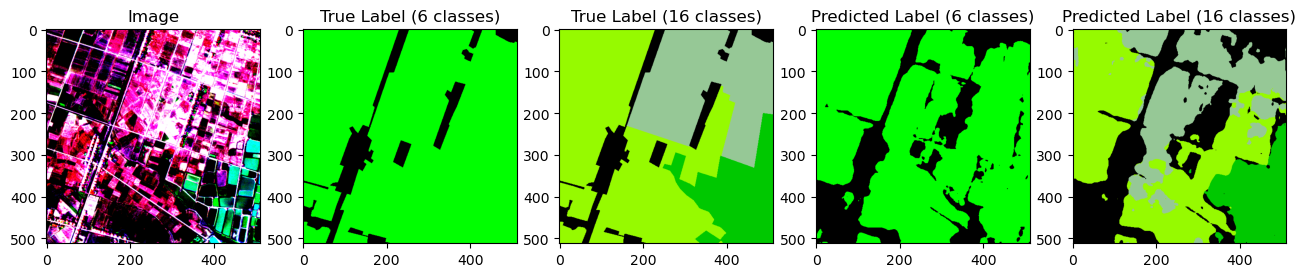

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


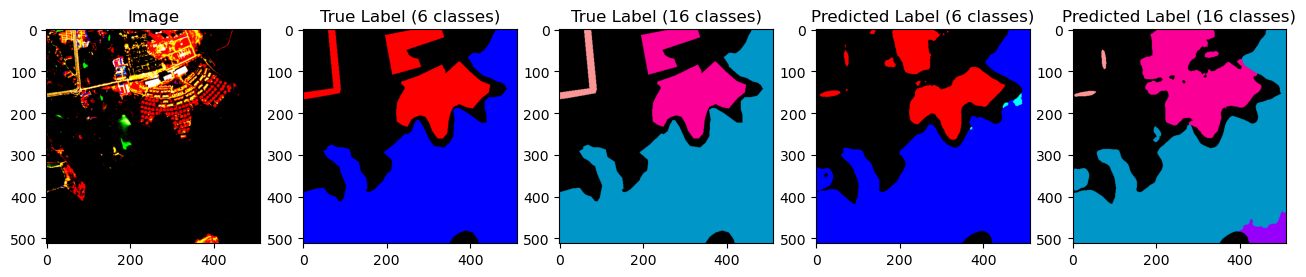

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


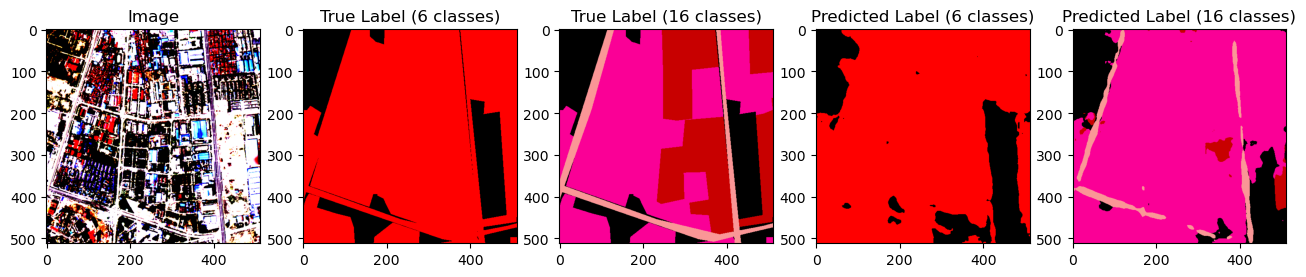

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


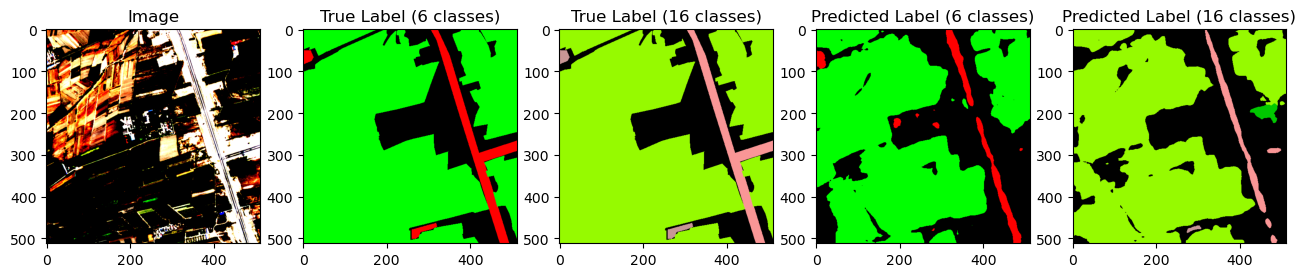

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


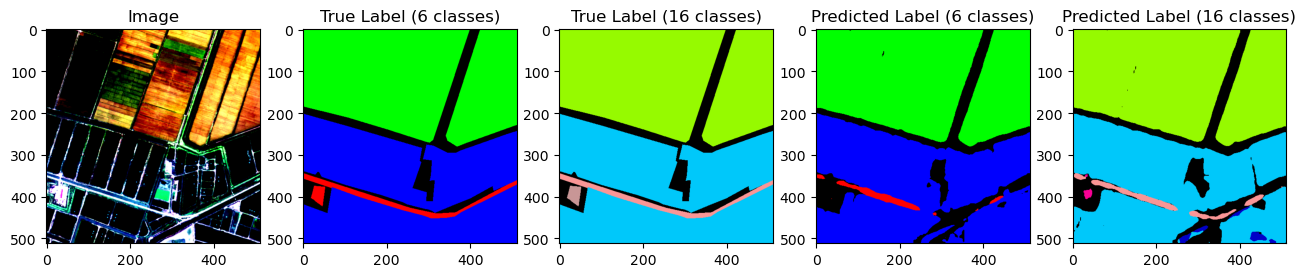

In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经定义了 COLORMAP_6c 和 COLORMAP_16c

cm1 = np.array(COLORMAP_6c).astype('uint8')
cm2 = np.array(COLORMAP_16c).astype('uint8')

def visualize_predictions(test_loader, model, device):
    model.eval()  # 将模型设为评估模式
    with torch.no_grad():  # 不计算梯度
        count = 0  # 初始化计数器
        for images, labels1, labels2 in test_loader:
            images, labels1, labels2 = images.to(device), labels1.to(device), labels2.to(device)
            
            # 获取模型的预测结果
            predictions, para = model(images)
            _, predicted_classes1 = torch.max(predictions[0], 1)
            _, predicted_classes2 = torch.max(predictions[1], 1)
            
            # 可视化图像、真实标签和预测结果
            for i in range(len(images)):
                if count == 5:  # 仅显示五张图片
                    return
                image = images[i].permute(1, 2, 0).cpu().numpy()  # 调整图像通道顺序
                true_label_6c = labels1[i].cpu().numpy()
                true_label_16c = labels2[i].cpu().numpy()
                true_label_6c = cm1[true_label_6c]
                true_label_16c = cm2[true_label_16c]
                true_label_6c = Image.fromarray(true_label_6c)
                true_label_16c = Image.fromarray(true_label_16c)
                
                predicted_label_6c = predicted_classes1[i].cpu().numpy()
                predicted_label_16c = predicted_classes2[i].cpu().numpy()
                predicted_label_6c = cm1[predicted_label_6c]
                predicted_label_16c = cm2[predicted_label_16c]
                predicted_label_6c = Image.fromarray(predicted_label_6c)
                predicted_label_16c = Image.fromarray(predicted_label_16c) 
                
                plt.figure(figsize=(16, 8))
                plt.subplot(2, 5, 1)
                plt.imshow(image)
                plt.title('Image')
                
                plt.subplot(2, 5, 2)
                plt.imshow(true_label_6c)
                plt.title('True Label (6 classes)')
                
                plt.subplot(2, 5, 3)
                plt.imshow(true_label_16c)
                plt.title('True Label (16 classes)')
                
                plt.subplot(2, 5, 4)
                plt.imshow(predicted_label_6c)
                plt.title('Predicted Label (6 classes)')
                
                plt.subplot(2, 5, 5)
                plt.imshow(predicted_label_16c)
                plt.title('Predicted Label (16 classes)')
                
                plt.show()
                count += 1

# 在测试集上可视化预测结果
visualize_predictions(test_data, model, device)


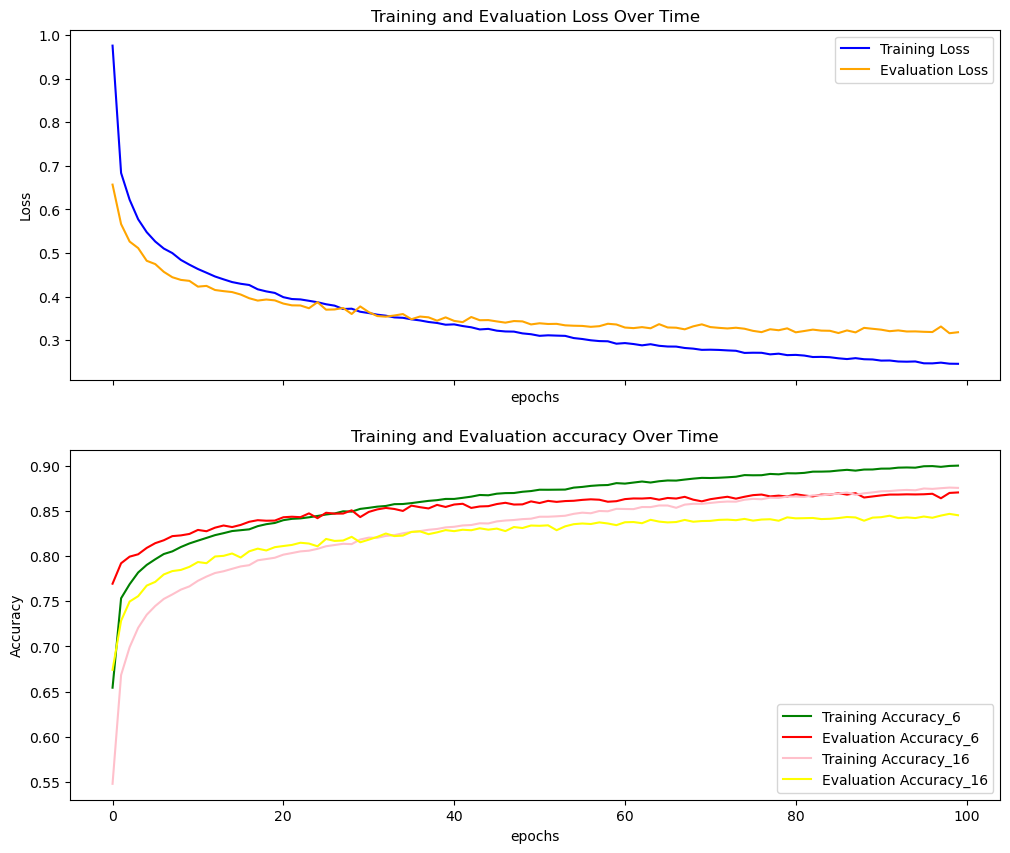

In [14]:
import json
import matplotlib.pyplot as plt

# 从 JSON 文件加载训练和评估日志
with open('D:/TSL/multimask/logs/unetformer/GID_split_hieraloss_SGD.json', 'r') as json_file:
    log_data = json.load(json_file)

# 创建一个包含两个子图的图表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# 绘制训练和评估损失
ax1.plot(log_data['train']['epochs'], log_data['train']['loss_6'], label='Training Loss', color='blue')
ax1.plot(log_data['eval']['epochs'], log_data['eval']['loss_6'], label='Evaluation Loss', color='orange')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Evaluation Loss Over Time')
ax1.legend()

# 绘制训练和评估准确率
ax2.plot(log_data['train']['epochs'], log_data['train']['accuracy_6'], label='Training Accuracy_6', color='green')
ax2.plot(log_data['eval']['epochs'], log_data['eval']['accuracy_6'], label='Evaluation Accuracy_6', color='red')
ax2.plot(log_data['train']['epochs'], log_data['train']['accuracy_16'], label='Training Accuracy_16', color='pink')
ax2.plot(log_data['eval']['epochs'], log_data['eval']['accuracy_16'], label='Evaluation Accuracy_16', color='yellow')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Evaluation accuracy Over Time')
ax2.legend()
# 绘制训练和评估准确率

plt.show()


## 加载测试数据

In [18]:
test_root = r"D:\TSL\data\GID10_clip"
def read_test(root=test_root):
    txt_fname = root + '/'+('test.txt')
    # print(txt_fname)
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root,'images',i+'.tif') for i in images]
    label1 = [os.path.join(root,'gtCoarse',i+'.tif') for i in images]
    label2 = [os.path.join(root,'gtFine',i+'.tif') for i in images]
    return data, label1, label2

In [19]:
def image_transforms(data,label1,label2): 
    # 将数据转换成tensor，并且做标准化处理

    im_tfs = tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    data = im_tfs(data)
    label1 = image2label_6(label1)
    label1 = torch.from_numpy(label1)
    label2 = image2label_16(label2)
    label2 = torch.from_numpy(label2)
    return data,label1,label2

In [20]:
class GIDtest(torch.utils.data.Dataset):
    
    # 构造函数
    def __init__(self, height, width, transforms):

        self.height = height
        self.width = width
        self.fnum = 0    # 用来记录被过滤的图片数
        self.transforms = transforms
        # data_list, label1_list, label2_list = read_images(train=train)
        data_list, label1_list,label2_list= read_test()
        self.data_list = self._filter(data_list)
        # self.label1_list = self._filter(label1_list)
        # self.label2_list = self._filter(label2_list)
        self.label1_list = self._filter(label1_list)
        self.label2_list = self._filter(label2_list)
        
                
        print("测试集：加载了 " + str(len(self.data_list)) + " 张图片和标签" + ",过滤了" + str(self.fnum) + "张图片")
        
    
    # 过滤掉长小于height和宽小于width的图片
    def _filter(self, images): 
        img = []
        for im in images:
            if (Image.open(im).size[1] >= self.height and 
               Image.open(im).size[0] >= self.width):
                img.append(im)
            else:
                self.fnum  = self.fnum+1
        return img
    
    # 重载getitem函数，使类可以迭代
    def __getitem__(self, idx):
        img = self.data_list[idx]
        label1 = self.label1_list[idx]
        label2 = self.label2_list[idx]
        # label =self.label_list[idx]
        
        img = Image.open(img)
        label1 = Image.open(label1).convert('RGB')
        label2 = Image.open(label2).convert('RGB')
        img, label1,label2  = self.transforms(img, label1,label2)
        return img, label1,label2
    
    def __len__(self):
        return len(self.data_list)

In [21]:
'''
image=(C,H,W)
label=(H,W)
'''
height = 512
width = 512
gid_test = GIDtest(height, width, image_transforms)
test_data = DataLoader(gid_test, batch_size=16,shuffle=True)#,num_workers=8

测试集：加载了 1600 张图片和标签,过滤了0张图片


## 加载最好的模型

In [26]:
model=model.cuda()
model.load_state_dict(torch.load(r"D:\TSL\multimask\pth\unetformer\split_hieraloss_jl\epoch-097_loss-0.2358_loss(val)-0.3254_acc-0.9051_miou-0.8339_miou(val)-0.7619.pth"))

<All keys matched successfully>

In [27]:
np.set_printoptions(suppress=True)
class_num_6=6
class_num_16=16
def fast_hist(a, b, n):
    """
    生成混淆矩阵
    a 是形状为(HxW,)的预测值
    b 是形状为(HxW,)的真实值
    n 是类别数
    """
    # 确保a和b在0~n-1的范围内，k是(HxW,)的True和False数列
    _,a = torch.max(a, dim=1)
    a = a.cpu().numpy()
    b = b.cpu().numpy()
    k = (a >= 0) & (a < n)
    # 横坐标是预测的类别，纵坐标是真实的类别
    hist = np.bincount(a[k].astype(int) + n * b[k].astype(int), minlength=n ** 2).reshape(n, n)
    # hist = np.delete(hist, 0, axis=0)
    # hist = np.delete(hist, 0, axis=1)
    # print(hist[20])
    return hist
 

def per_class_iou(hist):
    """
    hist传入混淆矩阵(n, n)
    """
    # 因为下面有除法，防止分母为0的情况报错
    np.seterr(divide="ignore", invalid="ignore")
    # 交集：np.diag取hist的对角线元素
    # 并集：hist.sum(1)和hist.sum(0)分别按两个维度相加，而对角线元素加了两次，因此减一次
    iou = np.diag(hist) / (hist.sum(1) + hist.sum(0) - np.diag(hist))
    # 把报错设回来
    #np.seterr(divide="warn", invalid="warn")
    # 如果分母为0，结果是nan，会影响后续处理，因此把nan都置为0
    iou[np.isnan(iou)] = 0.
    return iou
 
def per_class_acc(hist):
    """
    :param hist: 混淆矩阵
    :return: 没类的acc和平均的acc
    """
    np.seterr(divide="ignore", invalid="ignore")
    acc_cls = np.diag(hist) / hist.sum(1)
    np.seterr(divide="warn", invalid="warn")
    acc_cls[np.isnan(acc_cls)] = 0.
    return acc_cls
 

# 使用这个函数计算模型的各种性能指标
# 输入网络的输出值和标签值，得到计算结果
def get_MIoU6(pred, label, hist):
    """
    :param pred: 预测向量
    :param label: 真实标签值
    :return: 准确率，每类的准确率，每类的iou, miou
    """
    hist = hist + fast_hist(pred, label, class_num_6)
    # print(hist[20])
    # 准确率
    acc = np.diag(hist).sum() / hist.sum()
    # 每类的准确率
    acc_cls = per_class_acc(hist)
    # 每类的iou
    iou = per_class_iou(hist)
    miou = np.nanmean(iou[:])
    # 频率加权的 IoU (Frequency Weighted IoU, FWIoU)
    freq = hist.sum(1) / hist.sum()
    fwiou = (freq[freq > 0] * iou[freq > 0]).sum()
    
    # 平均每类准确率 (Mean Pixel Accuracy, mPA)
    mpa = np.nanmean(acc_cls)
    return acc, acc_cls, iou, miou, fwiou, mpa, hist

def get_MIoU16(pred, label, hist):
    """
    :param pred: 预测向量
    :param label: 真实标签值
    :return: 准确率，每类的准确率，每类的iou, miou
    """
    hist = hist + fast_hist(pred, label, class_num_16)
    # print(hist[20])
    # 准确率
    acc = np.diag(hist).sum() / hist.sum()
    # 每类的准确率
    acc_cls = per_class_acc(hist)
    # 每类的iou
    iou = per_class_iou(hist)
    miou = np.nanmean(iou[:])
    # 频率加权的 IoU (Frequency Weighted IoU, FWIoU)
    freq = hist.sum(1) / hist.sum()
    fwiou = (freq[freq > 0] * iou[freq > 0]).sum()
    
    # 平均每类准确率 (Mean Pixel Accuracy, mPA)
    mpa = np.nanmean(acc_cls)
    return acc, acc_cls, iou, miou, fwiou, mpa, hist

In [28]:
def test():
    hist1 = np.zeros((6,6))
    hist2 = np.zeros((16,16))
    acc_all1 =0
    acc_all2 =0
    miou_all1=0
    miou_all2=0
    model.eval()
    for step, data in enumerate(test_data):
        img,img_gt1,img_gt2= data
        img = img.to(device)
        img_gt1 = img_gt1.to(device)
        img_gt2 = img_gt2.to(device)
        # 前向传播
        output,parameter= model(img)
        # 计算各项性能指标
        acc1, acc_cls1, iou1, miou1, fwiou1, mpa1, hist1 = get_MIoU6(pred=output[0], label=img_gt1, hist=hist1)

        acc2, acc_cls2, iou2, miou2, fwiou2, mpa2, hist2 = get_MIoU16(pred=output[1], label=img_gt2, hist=hist2)
    print('acc1:',format(acc1, '.4f'))
    print('acc2:',format(acc2, '.4f'))
    print('miou1:',format(miou1,'.4f'))
    print('miou2:',format(miou2,'.4f'))
    print('fwiou1:',format(fwiou1,'.4f'))
    print('fwiou2:',format(fwiou2,'.4f'))
    print('mpa1:',format(mpa1,'.4f'))
    print('mpa2:',format(mpa2,'.4f'))
    print('acc_cls1:',np.array2string(acc_cls1, formatter={'all': lambda x: f'{x:.4f}'}))
    print('acc_cls2:',np.array2string(acc_cls2, formatter={'all': lambda x: f'{x:.4f}'}))
    print('iou1:',np.array2string(iou1, formatter={'all': lambda x: f'{x:.4f}'}))
    print('iou2:',np.array2string(iou2, formatter={'all': lambda x: f'{x:.4f}'}))
    print('hist:\n',hist1)
    print('hist:\n',hist2)


In [29]:
#97
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test()

acc1: 0.8654
acc2: 0.8469
miou1: 0.7689
miou2: 0.6992
fwiou1: 0.7659
fwiou2: 0.7385
mpa1: 0.8631
mpa2: 0.8030
acc_cls1: [0.8327 0.8694 0.8224 0.8978 0.8223 0.9340]
acc_cls2: [0.8455 0.7062 0.8553 0.7626 0.7018 0.5370 0.8621 0.5423 0.8622 0.8835
 0.8485 0.8157 0.8813 0.9534 0.9331 0.8578]
iou1: [0.6978 0.7562 0.7271 0.8379 0.6996 0.8948]
iou2: [0.7072 0.6034 0.7120 0.5961 0.5762 0.4149 0.7717 0.4477 0.7577 0.8229
 0.7388 0.6949 0.7421 0.9170 0.8903 0.7941]
hist:
 [[1.25026426e+08 1.24592220e+07 2.90184600e+06 7.43664900e+06
  1.23524400e+06 1.09154700e+06]
 [1.08397580e+07 7.45452680e+07 3.90600000e+03 3.10234000e+05
  6.61500000e+03 3.71210000e+04]
 [4.08422200e+06 4.57400000e+03 2.03862480e+07 3.02168000e+05
  6.72200000e+03 3.93400000e+03]
 [1.09884140e+07 3.39813000e+05 3.17806000e+05 1.06665054e+08
  2.63660000e+05 2.37554000e+05]
 [1.43444200e+06 2.34800000e+03 2.20950000e+04 7.83330000e+04
  7.11227600e+06 1.91000000e+02]
 [1.67669400e+06 2.50150000e+04 5.60400000e+03 3.53972000e

In [30]:
result=[]
with open(r"D:\TSL\data\GID10_clip\test.txt", encoding='utf-8') as f:
    for line in f:
        result.append(line.strip('\n').split('.')[0])
model=model.cuda()
model.eval()
cm1 = np.array(COLORMAP_6c).astype('uint8')
cm2 = np.array(COLORMAP_16c).astype('uint8')

def predict(img, label1,label2): # 预测结果
    img = Variable(img.unsqueeze(0)).cuda()
    out1,out = model(img)
    # print(out.shape)
    pred1 = out1[0].max(1)[1].squeeze().cpu().data.numpy()
    pred2 = out1[1].max(1)[1].squeeze().cpu().data.numpy()
    # print(pred.shape)
    # 将pred的分类值，转换成各个分类对应的RGB值
    pred1 = cm1[pred1]
    pred2 = cm2[pred2]
    # 将numpy转换成PIL对象
    pred1 = Image.fromarray(pred1)
    pred2 = Image.fromarray(pred2)
    return pred1,pred2,label1,label2

for i in range(6000):
    a=int(result[i])
    img_data,img_label1,img_label2 = gid_test[i]
    pred1,pred2,label1,label2 = predict(img_data,img_label1,img_label2)
    save_out1=r"D:\TSL\multimask\result\unetformer\mtl_jl\6"
    save_out2=r"D:\TSL\multimask\result\unetformer\mtl_jl\16"
    pred1.save(save_out1+ "/" + '%d.png'%a)
    pred2.save(save_out2+ "/" + '%d.png'%a)

IndexError: list index out of range